In [29]:
from sklearn.metrics import accuracy_score, classification_report , confusion_matrix , ConfusionMatrixDisplay
from tensorflow.keras.layers import SeparableConv2D, MaxPooling2D, BatchNormalization, Conv2D
from tensorflow.keras.layers import ActivityRegularization,GaussianDropout,SpatialDropout2D,Dropout
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Input,Flatten
from tensorflow.keras.layers import concatenate,Add
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from keras.models import load_model
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pickle as pkl
import pandas as pd

In [30]:
tf. __version__

'2.10.0'

In [31]:
model_name = 'C20'

In [32]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


<h1>Loading Dataset and images</h1>

In [33]:
train_df = pd.read_csv('./train.csv',index_col='id')
test_df = pd.read_csv('./test.csv',index_col='id')

In [34]:
train_df['label'] = train_df['label'].astype(str)

In [35]:
datagen=ImageDataGenerator(rescale=1./255,validation_split=0.15,rotation_range=20,  # Random rotation
                             width_shift_range=0.2,  # Random horizontal shift
                             height_shift_range=0.2,  # Random vertical shift
                             shear_range=0.2,  # Random shear
                             horizontal_flip=True)

In [36]:
train_generator = datagen.flow_from_directory(
    directory="./imageset/train/",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="sparse",
    target_size=(224, 224),
    subset="training"
)
validation_generator = datagen.flow_from_directory(
    directory="./imageset/train/",
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode="sparse",
    target_size=(224, 224),
    subset="validation"  # Specify that this is the validation set
)

Found 8053 images belonging to 10 classes.
Found 1416 images belonging to 10 classes.


In [37]:
# Get a batch of images and labels
images, labels = validation_generator.next()

# Check pixel values of the images
min_value = np.min(images)
max_value = np.max(images)
print(min_value,max_value)

if min_value >= -1 and max_value <= 1:
    print("Images are rescaled between -1 and 1.")
else:
    print("Images are not rescaled between -1 and 1.")

0.0 1.0
Images are rescaled between -1 and 1.


In [38]:
# train_images = pkl.load(open('./train_images.pickle','rb'))
# test_images = pkl.load(open('./test_images.pickle','rb'))

In [39]:
# train_images = train_images[:100]
# train_df = train_df.iloc[:100]

In [40]:
# train_images.shape

In [41]:
# X_train,X_val,y_train,y_val = train_test_split(train_images,train_df['label'],random_state=42)

In [42]:
# X_train.shape,X_val.shape,y_train.shape

In [43]:
# train_images = None

<h1>Model Architecture</h1>

In [44]:
def Module_1(filters,previous_layer,kernel=(3,3)):
    x = Conv2D(filters,kernel_size=kernel,padding='same',activation='relu')(previous_layer)
    x = Conv2D(filters,kernel_size=kernel,padding='same',activation='relu')(x)
    x = BatchNormalization()(x)
    # x = ActivityRegularization(l2=0.00001)(x)
    x = MaxPooling2D((2,2),strides=2,padding='same')(x)
    return x

In [45]:
def Module_2(filters,previous_layer,kernel=(3,3)):
    x = Conv2D(filters,kernel_size=kernel,padding='same',activation='relu')(previous_layer)
    x = BatchNormalization()(x)
    # x = Dropout(0.1)(x)
    return x

In [46]:
def Module_3(filters,previous_layer):
    x = Conv2D(filters,kernel_size=(3,3),padding='same',activation='relu')(previous_layer)
    x = BatchNormalization()(x)
    x = ActivityRegularization(l2=0.0001)(x)
    return x

In [47]:
# def Module_4(filters,previous_layer):
#     x1 = Conv2D(filters,kernel_size=(3,3),padding='same',dilation_rate=(1,1),activation='relu')(previous_layer)
#     x = BatchNormalization()(x1)
#     # x = MaxPooling2D((2,2),strides=3,padding='same')(x)
#     x = GaussianDropout(0.5)(x)
#     x = SeparableConv2D(filters,kernel_size=(3,3),padding='same',dilation_rate=(1,1),activation='relu')(x)
#     x = BatchNormalization()(x)
#     # x = MaxPooling2D((2,2),strides=3,padding='same')(x)
#     x = SeparableConv2D(filters,kernel_size=(3,3),padding='same',dilation_rate=(1,1),activation='relu')(x)
#     x = Add()([x,x1])

#     # x = MaxPooling2D((2,2),padding='same')(x)
#     return x

In [48]:
# def load_model_1(input_shape=(224,224,3),lr=0.001,classes=10):
#     base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=input_shape)
#     x = base_model.output
#     x = Flatten()(x)
#     x = Dense(128, activation='relu')(x)
#     output = Dense(classes, activation='softmax')(x)
#     # this is the model we will train
#     model = Model(inputs=base_model.input, outputs=output)
#     model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#     return model
    

In [56]:
def load_model_2(input_shape=(224,224,3),lr=0.001,classes=10):
    # Model val_accuracy= 74%
    input_layer = Input(shape = input_shape,name='Input_layer')
    x = Module_1(filters=64,previous_layer=input_layer)
    x = MaxPooling2D((2,2),strides=2,padding='same')(x)
    x = Module_2(filters=64,previous_layer=x)
    x = Module_2(filters=32,previous_layer=x,kernel=(5,5))
    x = Module_2(filters=16,previous_layer=x,kernel=(5,5))
    x = MaxPooling2D((2,2),strides=2,padding='same')(x)
    x = Module_2(filters=128,previous_layer=x,kernel=(3,3))
    x = Module_2(filters=48,previous_layer=x,kernel=(3,3))
    x = Module_2(filters=198,previous_layer=x,kernel=(3,3))
    x = MaxPooling2D((2,2),strides=2,padding='same')(x)
    x = Module_2(filters=198,previous_layer=x)
    x = Module_2(filters=128,previous_layer=x)
    x = Module_2(filters=256,previous_layer=x,kernel=(9,9))
    x1 = MaxPooling2D((2,2),strides=2,padding='same')(x)
    x1 = Module_2(filters=48,previous_layer=x)
    x1 = Module_2(filters=128,previous_layer=x1)

    # x1 = Add()[(x,x1)]

    # x = Module_2(filters=128,previous_layer=x,kernel=(3,3))

    # concat = Module_4(filters=256,previous_layer=concat)
    x = Flatten()(x1)
    x = Dense(64,activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(32,activation='relu')(x)

    output = Dense(classes,activation='softmax')(x)
    model = Model(inputs=input_layer,outputs=output) 
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr), loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return model
    

In [50]:
# def load_model_3(input_shape=(224,224,3),lr=0.001,classes=10):
#     base_model = EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=input_shape)
#     x = base_model.output
#     x = Flatten()(x)
#     x = Dense(128, activation='relu')(x)
#     output = Dense(classes, activation='softmax')(x)
#     # this is the model we will train
#     model = Model(inputs=base_model.input, outputs=output)
#     model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#     return model
    

In [57]:
# model = load_model_1(input_shape=train_generator.image_shape,lr=0.0001)
model = load_model_2(input_shape=train_generator.image_shape,lr=0.0001)
# model = load_model_3(input_shape=train_generator.image_shape,lr=0.0001)

c:\Users\Hazim\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [58]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_20 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_21 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 batch_normalization_8 (Batc  (None, 224, 224, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 56, 56, 64)       0   

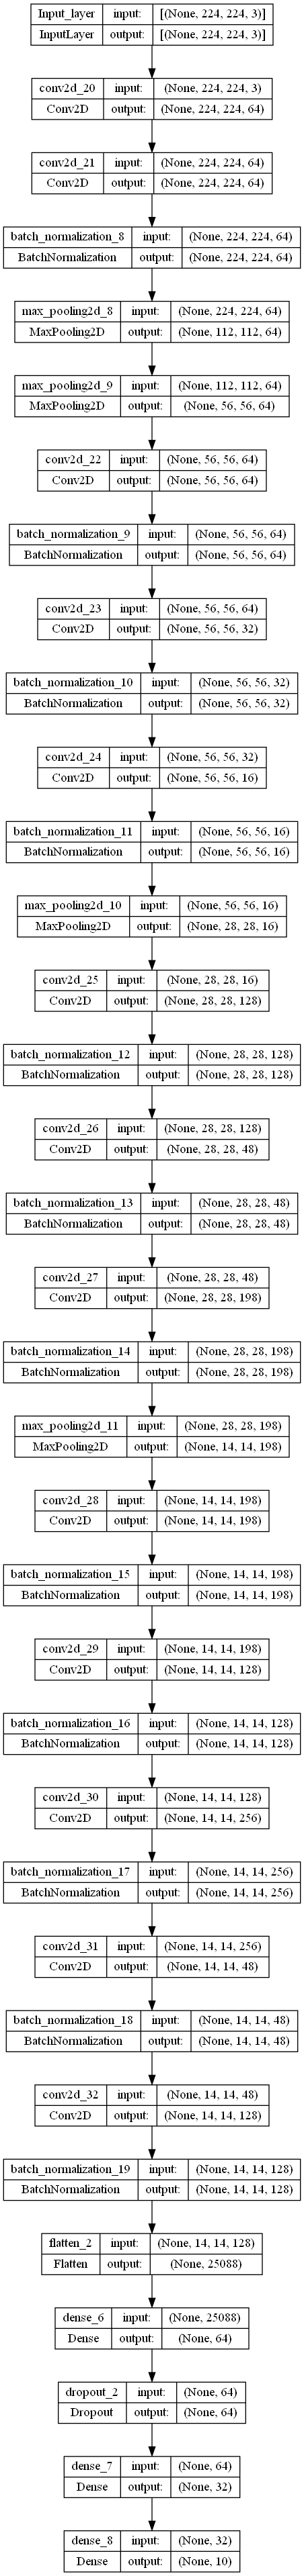

In [59]:
plot_model(model,show_shapes=True, show_layer_names=True)

In [60]:
# Define the checkpoint path and early stopping
checkpoint_path = f"model_checkpoint_class_{model_name}.h5"
checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True,monitor='val_accuracy',mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
# Loads the weights
# model.load_weights(checkpoint_path)

In [61]:
history = model.fit(train_generator,steps_per_epoch=len(train_generator),
                    epochs=100,
                    validation_data=validation_generator,
                    validation_steps=len(validation_generator),
                    verbose=1,
                    callbacks=[checkpoint,early_stopping])

Epoch 1/100
252/252 [==============================] - 120s 462ms/step - loss: 2.1767 - accuracy: 0.2261 - val_loss: 3.0587 - val_accuracy: 0.1017
Epoch 2/100
252/252 [==============================] - 118s 469ms/step - loss: 1.9893 - accuracy: 0.3217 - val_loss: 2.1877 - val_accuracy: 0.2804
Epoch 3/100
252/252 [==============================] - 117s 465ms/step - loss: 1.8624 - accuracy: 0.3754 - val_loss: 1.6991 - val_accuracy: 0.4357
Epoch 4/100
252/252 [==============================] - 123s 489ms/step - loss: 1.7641 - accuracy: 0.4215 - val_loss: 1.7394 - val_accuracy: 0.4308
Epoch 5/100
252/252 [==============================] - 125s 495ms/step - loss: 1.7030 - accuracy: 0.4448 - val_loss: 1.6992 - val_accuracy: 0.4534
Epoch 6/100
252/252 [==============================] - 121s 479ms/step - loss: 1.6280 - accuracy: 0.4747 - val_loss: 1.5573 - val_accuracy: 0.5085
Epoch 7/100
252/252 [==============================] - 113s 446ms/step - loss: 1.5453 - accuracy: 0.4991 - val_loss: 1

In [62]:
model.load_weights(checkpoint_path)

In [63]:
def plot_history(history,metrics):
    plt.plot(history.history[metrics])
    plt.plot(history.history['val_'+metrics])
    plt.title(f'model {metrics}')
    plt.ylabel(f'{metrics}') 
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

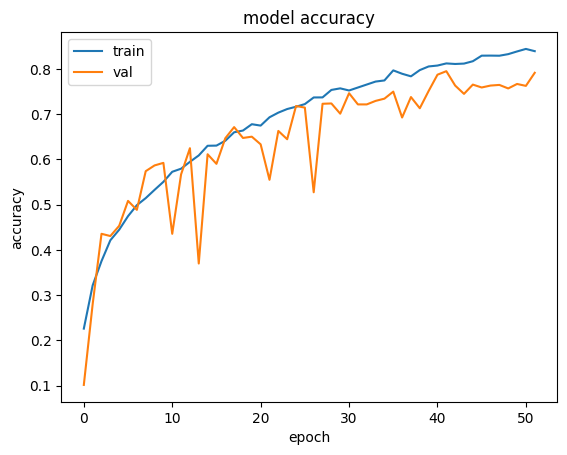

In [64]:
plot_history(history,metrics='accuracy')

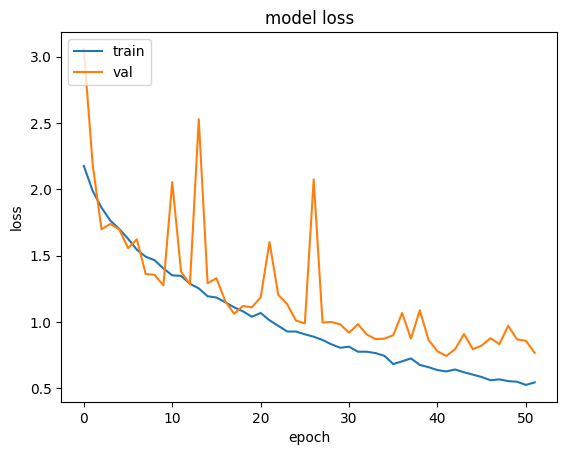

In [65]:
plot_history(history,metrics='loss')

In [66]:
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size+1
model.evaluate(validation_generator,
steps=STEP_SIZE_VALID)

45/45 [==============================] - 16s 358ms/step - loss: 0.7763 - accuracy: 0.7754


[0.7762822508811951, 0.7754237055778503]

In [67]:
# Get true labels for validation set
STEP_SIZE_TEST=validation_generator.n//validation_generator.batch_size+1
validation_generator.reset()
y_pred=model.predict(validation_generator,
steps=STEP_SIZE_TEST,
verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels
y_true = validation_generator.classes


# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

45/45 [==============================] - 17s 370ms/step


In [68]:
np.unique(y_pred_classes)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

Accuracy: 0.780367231638418
Classwise Classification Report: 
              precision    recall  f1-score   support

           0       0.78      0.92      0.84       144
           1       0.83      0.92      0.87       143
           2       0.86      0.83      0.85       144
           3       0.72      0.79      0.75       148
           4       0.59      0.65      0.62       128
           5       0.83      0.67      0.75       141
           6       0.89      0.82      0.85       143
           7       0.79      0.81      0.80       144
           8       0.76      0.71      0.73       139
           9       0.77      0.67      0.72       142

    accuracy                           0.78      1416
   macro avg       0.78      0.78      0.78      1416
weighted avg       0.78      0.78      0.78      1416


Confusion Matrix: 


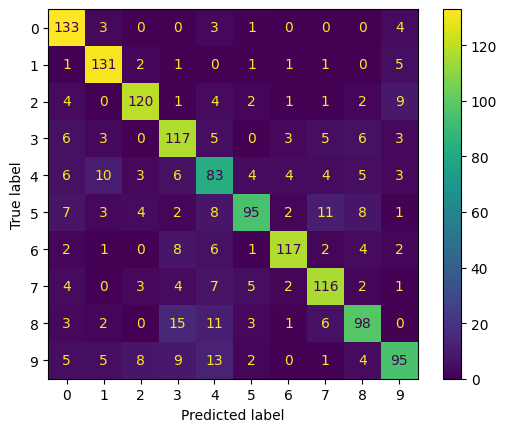

In [69]:
print(f"Accuracy: {accuracy_score(y_true, y_pred_classes)}")
print(f"Classwise Classification Report: \n{classification_report(y_true, y_pred_classes)}")
con_matrix = confusion_matrix(np.ravel(y_true), y_pred_classes)
print("\nConfusion Matrix: ")
con_matrix = ConfusionMatrixDisplay(con_matrix)
con_matrix.plot()
plt.show()

In [70]:
model.save(f'./Models/{model_name}_custom.h5')

In [72]:
# Load the model from the file
model = load_model(f"./Models/{model_name}_custom.h5")